# Detailed Exploration of Universal Gate Set for small zeta

## Header

In [45]:
import numpy as np
import QDYN
from QDYN.shutil import mkdir
from QDYN.pulse import Pulse, pulse_tgrid
from QDYN.gate2q import Gate2Q
from QDYN.linalg import norm, vectorize
from os.path import join
from notebook_utils import (
    get_zeta_table, plot_zeta_data, filter_table, get_logical_energies_table,
    get_stage4_table, bare_decomposition, get_transition_table, J_target,
    get_w_d_from_config, read_target_gate)
from mgplottools.io import writetotxt
from select_for_stage4 import GATE_RE, GATE_IM, GATE
from generate_zeta_universal import write_config
from analytical_pulses import AnalyticalPulse
from run_oct import propagate
from collections import OrderedDict
from zeta_systematic_variation import systematic_variation
import pandas as pd
import QDYNTransmonLib
from mgplottools.io import writetotxt
import json

In [46]:
H_left = GATE['H_left']
H_right = GATE['H_right']
S_left = GATE['Ph_left']
S_right = GATE['Ph_right']
sqrt_SWAP = QDYN.gate2q.sqrt_SWAP
sqrt_iSWAP = QDYN.gate2q.sqrt_iSWAP
BGATE = QDYN.gate2q.BGATE
GATE_RE['sqrt_SWAP'] = QDYN.linalg.vectorize(sqrt_SWAP).real
GATE_IM['sqrt_SWAP'] = QDYN.linalg.vectorize(sqrt_SWAP).imag
GATE_RE['sqrt_iSWAP'] = QDYN.linalg.vectorize(sqrt_iSWAP).real
GATE_IM['sqrt_iSWAP'] = QDYN.linalg.vectorize(sqrt_iSWAP).imag
GATE_RE['BGATE'] = QDYN.linalg.vectorize(BGATE).real
GATE_IM['BGATE'] = QDYN.linalg.vectorize(BGATE).imag
def write_target_gate_dat(rf, gate):
    writetotxt(join(rf, 'target_gate.dat'), GATE_RE[gate], GATE_IM[gate])

In [47]:
def J_PE(U):
    if U is None:
        return None
    else:
        C = U.closest_unitary().concurrence()
        max_loss = np.max(1.0 - U.logical_pops())
        return J_target('PE', C, max_loss)

def F_avg_H_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_left)
    
def F_avg_H_right(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_right)

def F_avg_S_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(S_left)
    
def F_avg_S_right(U):
    if U is None:
        return None
    else:
        return U.F_avg(S_right)

In [48]:
from multiprocessing import Process
import os
def system(cmd):
    p = Process(target=os.system, args=(cmd,))
    p.start()
    return p

In [49]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [50]:
get_zeta_table = QDYN.memoize.memoize(get_zeta_table)
get_zeta_table.load('zeta_table.cache')

In [51]:
zeta_table = get_zeta_table('./runs_050_RWA', T=50)

In [52]:
w_max = 1.0 # minimum frequency in the rotating frame to be resolved. (for calculation of nt)

In [53]:
n_qubit = 5; n_cavity = 6

In [68]:
def mark_freqs(rf, transition_table):
    """Return the frequencies that should be highlighted in the spectrum plot"""
    w_d = get_w_d_from_config(join(rf, 'config'))
    w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
    w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
    w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
    w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz
    wc = 6.2 # GHZ
    w2 = 5.9 # GHz
    w1 = 6.00 # GHz
    return [(w1_dressed0-w_d, {'color':'black', 'ls':'--'}),
            (w1_dressed1-w_d, {'color':'black', 'ls':'--'}),
            (w2_dressed0-w_d, {'color':'gray', 'ls':'--'}),
            (w2_dressed1-w_d, {'color':'gray', 'ls':'--'}),
            (wc-w_d,          {'color':'gray', 'ls':'dotted'}),
            (w2-w_d,          {'color':'gray', 'ls':'-.'}),
            (w1-w_d,          {'color':'black', 'ls':'-.'})]

## Properties of the Hamiltonian

In [55]:
wc = 6.2 # GHZ
w2 = 5.9 # GHz
w1 = 6.00 # GHz
root = './runs_zeta_detailed/w2_%dMHz_wc_%dMHz' % (w2*1000, wc*1000)
mkdir(root)

* what is the the entangling energy?

In [56]:
zeta = float(filter_table(zeta_table, [(w2, wc),])['zeta [MHz]']); zeta

0.29699999999999704

In [57]:
T_entangling = 500.0 / abs(zeta); T_entangling # ns

1683.5016835017002

In [58]:
T = 50
rf = join(root, 'analyze_ham'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()
print "pop loss: %.5f" % U.pop_loss()

concurrence: 0.04580
pop loss: 0.00448


In [59]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/analyze_ham'

In [60]:
psi = {}; psi['00'], psi['01'], psi['10'], psi['11'] \
= np.genfromtxt(join(rf, 'logical_states.dat'), unpack=True, usecols=range(4))
for label in ['00', '01', '10', '11']:
    print("%s = %s" % (label, bare_decomposition(psi[label], n_qubit, n_cavity)))

00 = 100.0% {000}
01 = 5.9% {001} + 92.0% {010} + 2.1% {100}
10 = 5.7% {001} + 4.2% {010} + 90.1% {100}
11 = 0.7% {002} + 7.9% {011} + 0.6% {020} + 3.4% {101} + 86.0% {110} + 1.4% {200}


In [61]:
transition_table = get_transition_table(filter_table(zeta_table, [(w2, wc),]))
transition_table.reset_index(drop=True)

,E01 - E00 [MHz],E10 - E00 [MHz],E11 - E10 [MHz],E11 - E01 [MHz],bare w2 [MHz],bare w1 [MHz]
0,5882.25,5982.323,5882.547,5982.62,5900,6000


In [62]:
w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz

In [63]:
print w1_dressed0
print w1_dressed1
print w2_dressed0
print w2_dressed1

5.982323
5.98262
5.88225
5.882547


In [64]:
w1_dressed = 0.5 * (w1_dressed0 + w1_dressed1)
w2_dressed = 0.5 * (w2_dressed0 + w2_dressed1)

In [65]:
print("Separation of dressed frequencies, left qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E01 [MHz]']) - float(transition_table['E10 - E00 [MHz]'])))
print("Separation of dressed frequencies, right qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E10 [MHz]']) - float(transition_table['E01 - E00 [MHz]'])))

Separation of dressed frequencies, left qubit: 0.297 MHz
Separation of dressed frequencies, right qubit: 0.297 MHz


In [66]:
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')

Spectral resolution of pulse: 20.0 MHz


* What is the truncated drive-Hamiltonian in the dressed basis?

In [22]:
! tm_en_logical_eigenstates --ctrl {rf}

*** Read config file ./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/analyze_ham/config ***
*** Done reading config file ***
control Hamiltonian in the eigenbasis will be written to ham_ctrl_diag.dat
All eigenstates will be written to eigenstates.dump
Starting on Fri Mar 25 16:51:26 -0700 2016

This is tm_en_logical_eigenstates                                        rev.03508eb57aa9da474d018ba0a80756003104b893
 compiled on Tue Mar 22 18:27:41 2016 on host mlhpc2
QDYN 2.0dev revision 50b2d685df2070f8ff93d299e6b374b322a10cb7 (UNKNOWN)
  features: no-check-cheby, no-check-newton, no-parallel-ham, parallel-oct, backtraces
  compiled with ifort on Tue Mar 22 18:10:49 2016 on host mlhpc2

Number of qubit levels        =    5
Number of cavity levels       =    6
size(H):     150 x     150   --      0 MB

Orig. logical subspace levels:    1,    7,   31,   37

 Diagonalizing Drift Hamiltonian
 Done
 
level   114 in logical subspace (100.0000000% \Ket{000})
level   105 in logical subspace ( 91.998236

In [23]:
ctrl_dressed_i, ctrl_dressed_j = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(0,1), unpack=True, dtype=np.int)

In [24]:
ctrl_dressed_vals = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(2,), unpack=True, dtype=np.float64)

In [25]:
logical_levels = [114, 105, 112, 104]

In [26]:
ctrl_ham = np.zeros(shape=(4,4))
for l, v in enumerate(ctrl_dressed_vals):
    if ctrl_dressed_i[l] in logical_levels and ctrl_dressed_j[l] in logical_levels:
        i = logical_levels.index(ctrl_dressed_i[l])
        j = logical_levels.index(ctrl_dressed_j[l])
        if abs(v) > 1e-10:
            ctrl_ham[i,j] = v

In [27]:
print(ctrl_ham)

[[ 0.         -0.12157498 -0.11985052  0.        ]
 [-0.12157498  0.          0.         -0.16294268]
 [-0.11985052  0.          0.         -0.07343955]
 [ 0.         -0.16294268 -0.07343955  0.        ]]


### Best reachable gate error

In [472]:
1-U.F_avg(U.closest_unitary())

0.00448619165862707

In [473]:
T = 40
rf = join(root, 'analyze_ham'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
1-U.F_avg(U.closest_unitary())

0.0035910577413055256

In [474]:
T = 30
rf = join(root, 'analyze_ham'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
1-U.F_avg(U.closest_unitary())

0.0026948721028861033

In [475]:
T = 20
rf = join(root, 'analyze_ham'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
1-U.F_avg(U.closest_unitary())

0.0017976365207068579

We can compare this to the lower bound for *any* parameter point

In [476]:
from notebook_utils import diss_error

In [477]:
diss_error(1.2e-5, 50)

0.0037606901757964994

In [478]:
diss_error(1.2e-5, 40)

0.0030100253361254881

In [479]:
diss_error(1.2e-5, 30)

0.0022586247101816781

In [480]:
diss_error(1.2e-5, 20)

0.0015064874869812339

### Controllability

We can do a controllability analysis of the truncated Hamiltonian, using the program `git@jerusalem.physik.uni-kassel.de:goerz/PEcontrollability`

In [350]:
w = QDYN.weyl.WeylChamber()

Controllability can be visualized by propagating in time steps of 10ns, using a ramdom pulse amplitude in each step (up to 1GHz; blue)

In [351]:
t, c1, c2, c3 = np.genfromtxt(join(rf, 'transmon_landscape_cloud.dat'), unpack=True)

In [352]:
w.scatter(c1, c2, c3, color='blue')

We can also look at the path in the Weyl chamber when driving with a constant max pulse amplitude for 100 ns (red)

In [353]:
t, c1, c2, c3 = np.genfromtxt(join(rf, 'transmon_landscape_path.dat'), unpack=True)

In [354]:
w.scatter(c1, c2, c3, color='red')

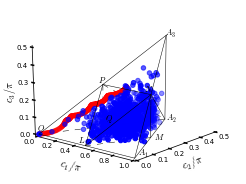

In [355]:
w.show()

## "Stage 4" results

### Stage3 continuation

#### PE - continued from stage3

In [47]:
rf = './runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/PE_1freq'

In [48]:
U_PE = propagate(rf, 'pulse.dat', rwa=True, keep=True, force=True)

In [49]:
! cat {rf}/config | grep w_d

w_d = 5932.447856_MHz, &


In [50]:
U_PE.pop_loss()

0.0054792730019286306

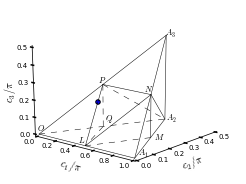

In [51]:
U_PE.show_in_weyl_chamber()

In [52]:
U_closest_PE = U_PE.closest_PE()

In [53]:
1-U_PE.F_avg(U_closest_PE)

0.0054810376621311496

In [37]:
U_target_PE = read_target_gate(rf+'/target_gate.dat')

In [40]:
1 - U_PE.F_avg(U_target_PE)

0.0054815980248310581

In [42]:
pulse_PE = Pulse(rf='/pulse.dat')

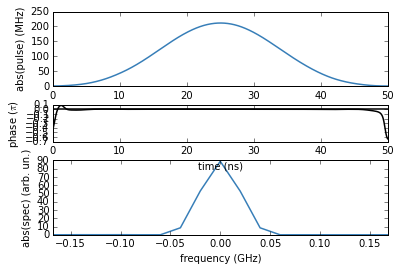

In [43]:
pulse_PE.show()

In [44]:
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)

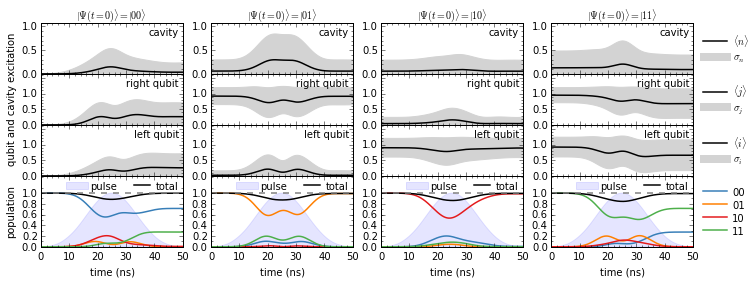

In [45]:
dyn.show()

#### Local Gates - continued from stage3

In [55]:
U_HL = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_H_left', 'pulse.dat', rwa=True, keep=None, force=True)
U_HR = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_H_right', 'pulse.dat', rwa=True, keep=None, force=True)
U_SL = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_Ph_left', 'pulse.dat', rwa=True, keep=None, force=True)
U_SR = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_Ph_right', 'pulse.dat', rwa=True, keep=None, force=True)

In [57]:
1 - U_HL.F_avg(H_left)

0.0075158005242521586

In [58]:
1 - U_HR.F_avg(H_right)

0.0085389958986326064

In [60]:
1 - U_SL.F_avg(S_left)

0.0061055576024937608

In [60]:
1 - U_SL.F_avg(S_left)

0.0061055576024937608

Using a pre-simplex instead of directly continuing from stage3 yields the same results.

## Analysis of PE result

Optimized pulse is very simple (just a Blackman of the right amplitude), so maybe we can understand the gate a little bit better by seeing what happens in the population dynamics when we ramp up the amplitude from zero to the amplitude that implements the PE.

In [38]:
rf = join(root, 'analyze_stage4_PE'); mkdir(rf)
! cp ./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/PE_1freq/* {rf}/

In [39]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/analyze_stage4_PE'

In [40]:
pulse = AnalyticalPulse('1freq_rwa', T=50, nt=2000, time_unit='ns', ampl_unit='MHz',
                        parameters={'E0':0, 'T':50, 'w_L': 5.932442958862661, 
                                    'w_d': 5.932442958862661})

Concurrence: 0.0458042543442
Loss: 0.00448414597022


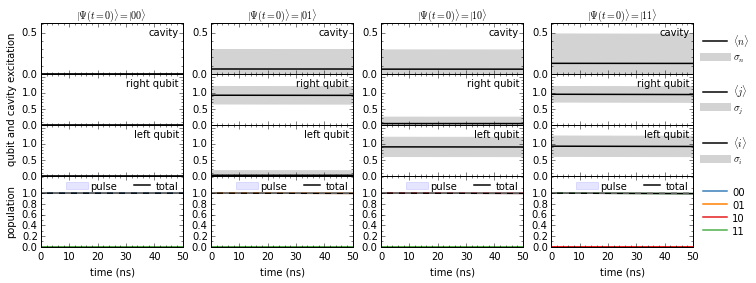

In [44]:
pulse.parameters['E0'] = 0.0
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

Concurrence: 0.542123470378
Loss: 0.00462538567073


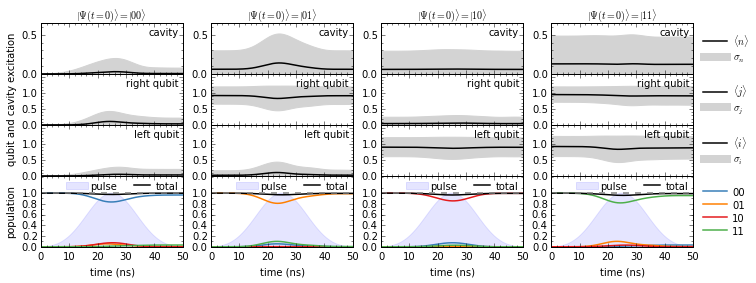

In [46]:
pulse.parameters['E0'] = 100
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

Concurrence: 0.859652254126
Loss: 0.00484554218148


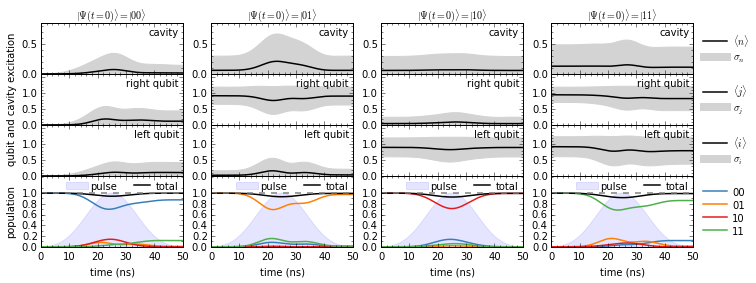

In [47]:
pulse.parameters['E0'] = 150
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

Concurrence: 0.99999934885
Loss: 0.00548104151986


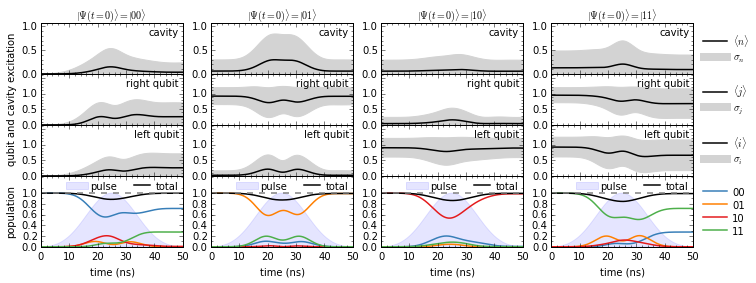

In [45]:
pulse.parameters['E0'] = 211.84807950325194
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

## Further OCT

### PE

#### Shorter time duration

* $T = 40$

In [204]:
wd = 5.9325
rf = join(root, 'PE_40ns'); mkdir(rf)
T = 40

In [205]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_40ns'

In [54]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [55]:
proc = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [56]:
proc

<Process(Process-1, started)>

In [63]:
proc.join();

In [64]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [65]:
U.closest_unitary().concurrence()

0.99998071887803075

In [67]:
1-U.F_avg(U.closest_unitary())

0.0052472032625618947

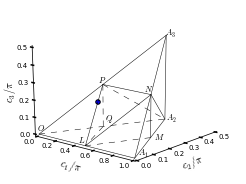

In [72]:
U.show_in_weyl_chamber()

In [206]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

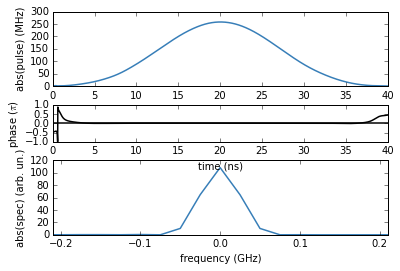

In [207]:
p.show()

* $T = 30$

In [208]:
wd = 5.9325
rf = join(root, 'PE_30ns'); mkdir(rf)
T = 30

In [209]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_30ns'

In [59]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [60]:
proc2 = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [61]:
proc2.join()

<Process(Process-2, started)>

In [210]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [211]:
U.closest_unitary().concurrence()

1.0

In [212]:
1-U.F_avg(U.closest_unitary())

0.0055514751643859217

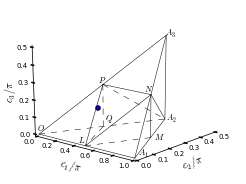

In [213]:
U.show_in_weyl_chamber()

In [214]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

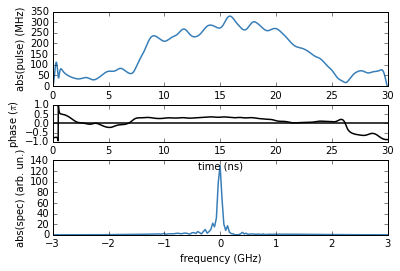

In [215]:
p.show()

* $T = 20$

In [216]:
wd = 5.9325
rf = join(root, 'PE_20ns'); mkdir(rf)
T = 20

In [217]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_20ns'

In [70]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [71]:
proc3 = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [61]:
proc3.join()

<Process(Process-2, started)>

In [218]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [219]:
U.closest_unitary().concurrence()

0.99822967378516514

In [220]:
1-U.F_avg(U.closest_PE())

0.0047394461318799319

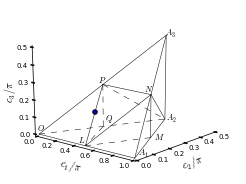

In [221]:
U.show_in_weyl_chamber()

In [222]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

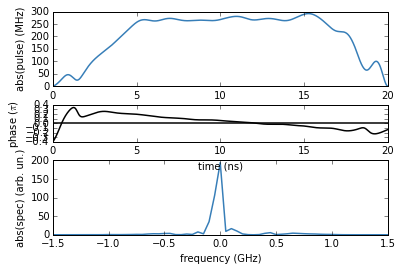

In [223]:
p.show()

* $T = 15$

In [224]:
wd = 5.9325
rf = join(root, 'PE_15ns'); mkdir(rf)
T = 15

In [225]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_15ns'

In [153]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [154]:
proc8 = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=50 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [155]:
proc8.join()

<Process(Process-22, started)>

In [226]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [227]:
U.closest_unitary().concurrence()

0.94892596082022873

In [228]:
1-U.F_avg(U.closest_PE())

0.014080369349750099

In [232]:
U.pop_loss()

0.0038692418400962936

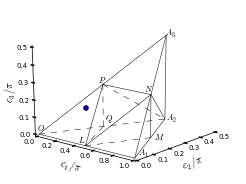

In [233]:
U.closest_unitary().show_in_weyl_chamber()

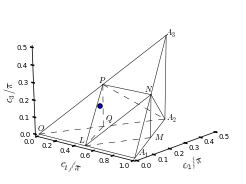

In [234]:
U.closest_PE().show_in_weyl_chamber()

In [230]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

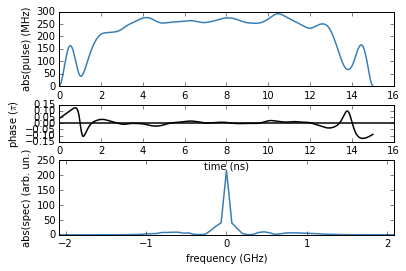

In [231]:
p.show()

#### Known efficient gates

For arbitrary PE, it is not clear whether they are "efficient" as part of a universal set (i.e., only a small number of applications are needed). Therefore, we try to get to some more "special" points in the Weyl chamber.

##### SQRT(SWAP) at $T = 50ns$

In [235]:
wd = 5.9325
rf = join(root, 'PE_sqrtSWAP_50ns'); mkdir(rf)
T = 50

In [236]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_sqrtSWAP_50ns'

In [79]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')
write_target_gate_dat(rf, 'sqrt_SWAP')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [80]:
proc4 = system("./run_oct.py --continue --threads --target=target_gate.dat --rwa --scan=systematic_variation.json --vary=E0 --nt-min=4000 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [81]:
proc4.join()

<Process(Process-4, started)>

In [237]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [238]:
U.closest_unitary().concurrence()

0.99982528842039997

In [239]:
1-U.F_avg(sqrt_SWAP)

0.020952265228012856

In [240]:
U.pop_loss()

0.020055033317791793

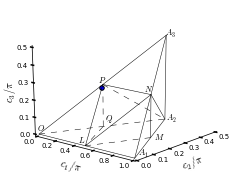

In [241]:
U.closest_unitary().show_in_weyl_chamber()

In [242]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

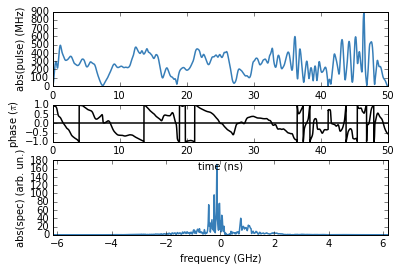

In [243]:
p.show()

##### SQRT(SWAP) at $T = 50ns$, no pre-simplex

Simplex did not seem successful, so let's try with a significant pulse amplitude instead

In [244]:
wd = 5.9325
rf = join(root, 'PE_sqrtSWAP_50ns_no_simplex'); mkdir(rf)
T = 50

In [245]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_sqrtSWAP_50ns_no_simplex'

In [87]:
# write runfolder
nt = 4000
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')
write_target_gate_dat(rf, 'sqrt_SWAP')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.pulse().write(join(rf, 'pulse.guess'))

In [88]:
proc5 = system("./run_oct.py --continue --threads --target=target_gate.dat --rwa {rf}".format(rf=rf))

In [200]:
proc5.join()

In [246]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [247]:
U.closest_unitary().concurrence()

0.99998704241693881

In [248]:
1-U.F_avg(sqrt_SWAP)

0.0085158743847969509

In [249]:
U.pop_loss()

0.0084497504097104104

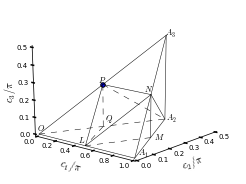

In [250]:
U.closest_unitary().show_in_weyl_chamber()

In [251]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

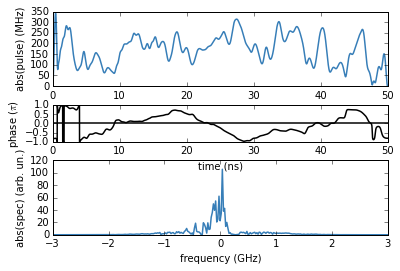

In [252]:
p.show()

##### SQRT(iSWAP) at $T = 50ns$, no pre-simplex

In [280]:
wd = 5.9325
rf = join(root, 'PE_sqrtISWAP_50ns_no_simplex'); mkdir(rf)
T = 50

In [281]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_sqrtISWAP_50ns_no_simplex'

In [198]:
# write runfolder
nt = 4000
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')
write_target_gate_dat(rf, 'sqrt_iSWAP')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.pulse().write(join(rf, 'pulse.guess'))

In [199]:
proc5 = system("./run_oct.py --continue --threads --target=target_gate.dat --rwa {rf}".format(rf=rf))

In [ ]:
proc5.join()

In [282]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [283]:
U.closest_unitary().concurrence()

0.99993893493778674

In [284]:
1-U.F_avg(sqrt_iSWAP)

0.0079208620066495428

In [285]:
U.pop_loss()

0.0078994376980726644

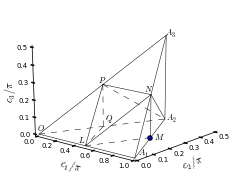

In [286]:
U.closest_unitary().show_in_weyl_chamber()

In [287]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

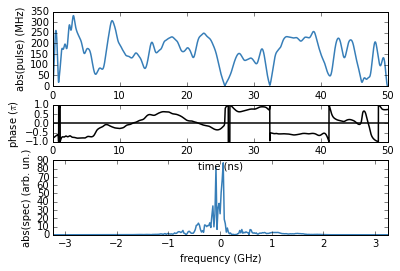

In [288]:
p.show()

#### Efficient gates II (LI)

Note that simplex search is not implemented for LI optimization, so we skip it

##### LI SQRT(iSWAP) at $T = 50ns$

In [304]:
wd = 5.9325
rf = join(root, 'PE_LI_sqrtISWAP_50ns'); mkdir(rf)
T = 50

In [305]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_LI_sqrtISWAP_50ns'

In [189]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='LI', prop_guess='F')
write_target_gate_dat(rf, 'sqrt_iSWAP')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.pulse().write(join(rf, 'pulse.guess'))

In [190]:
proc6 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf))

In [ ]:
proc6.join()

In [291]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [292]:
U.closest_unitary().concurrence()

0.97692632341564989

In [293]:
1-U.F_avg(sqrt_SWAP)

0.75558272140410709

In [294]:
U.pop_loss()

0.0049511628580924949

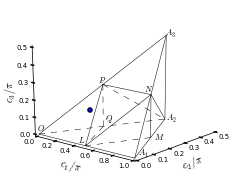

In [295]:
U.closest_unitary().show_in_weyl_chamber()

In [296]:
p = QDYN.pulse.Pulse(join(rf, 'pulse.dat'))

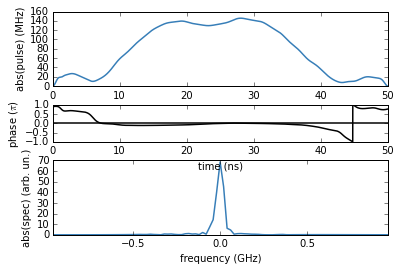

In [297]:
p.show()

In [389]:
rf2 = join(root, 'PE_LI_sqrtISWAP_50ns_cont'); mkdir(rf2)

In [307]:
! cp {rf}/* {rf2}/
! mv {rf2}/pulse.dat {rf2}/pulse.guess
! perl -p -i -e 's/LI_unitarity_weight = 0.01/LI_unitarity_weight = 0.5/g' {rf2}/config

In [310]:
proc6 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf2))

In [311]:
proc6.join()

<Process(Process-37, started)>

In [357]:
U = propagate(rf2, 'pulse.dat', rwa=True, force=True);

In [358]:
U.closest_unitary().concurrence()

0.99999856936730624

In [359]:
1-U.F_avg(sqrt_SWAP)

0.75753822316820951

In [360]:
U.pop_loss()

0.0055034216415124071

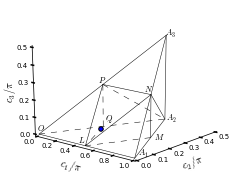

In [361]:
U.closest_unitary().show_in_weyl_chamber()

In [362]:
p = QDYN.pulse.Pulse(join(rf2, 'pulse.dat'))

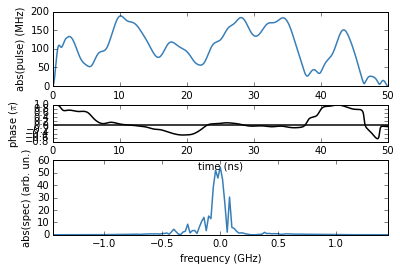

In [363]:
p.show()

In [481]:
rf3 = join(root, 'PE_LI_sqrtISWAP_50ns_cont2'); mkdir(rf3)

In [391]:
! cp {rf2}/* {rf3}/
! mv {rf3}/pulse.dat {rf3}/pulse.guess
! perl -p -i -e 's/LI_unitarity_weight = 0.5/LI_unitarity_weight = 0.9/g' {rf3}/config
! perl -p -i -e 's/J_T_conv = 1.0e-3/J_T_conv = 1.0e-5/g' {rf3}/config

In [392]:
proc6 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf3))

In [394]:
proc6.join()

<Process(Process-42, started)>

In [482]:
U = propagate(rf3, 'pulse.dat', rwa=True, force=True);

In [483]:
U.closest_unitary().concurrence()

0.9999995406690998

In [490]:
U.closest_PE().weyl_coordinates()

(0.27809572, 0.22190428, 0.00025859)

In [485]:
1-U.F_avg(U.closest_PE())

0.0055657097216270657

In [486]:
U.pop_loss()

0.0055645627718963198

In [491]:
sqrt_iSWAP2 = QDYN.weyl.closest_LI(U, 0.25, 0.25, 0.0)

In [492]:
1-U.F_avg(sqrt_iSWAP2)

0.0086598382127778262

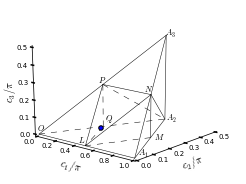

In [487]:
U.closest_unitary().show_in_weyl_chamber()

In [488]:
p = QDYN.pulse.Pulse(join(rf3, 'pulse.dat'))

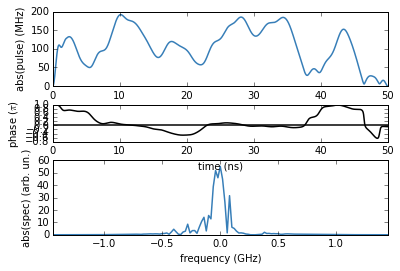

In [489]:
p.show()

##### LI BGATE at $T = 50ns$

In [312]:
wd = 5.9325
rf = join(root, 'PE_LI_BGATE_50ns'); mkdir(rf)
T = 50

In [313]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_LI_BGATE_50ns'

In [144]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='LI', prop_guess='F')
write_target_gate_dat(rf, 'BGATE')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.pulse().write(join(rf, 'pulse.guess'))

In [145]:
proc7 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf))

In [191]:
proc7.join()

In [314]:
U = propagate(rf, 'pulse.dat', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()
print "pop loss: %.5f" % U.pop_loss()

concurrence: 1.00000
pop loss: 0.00525


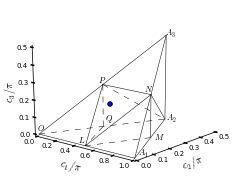

In [315]:
U.closest_unitary().show_in_weyl_chamber()

In [386]:
rf2 = join(root, 'PE_LI_BGATE_50ns_cont'); mkdir(rf2)

In [365]:
rf2

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_LI_BGATE_50ns_cont'

In [319]:
! cp {rf}/* {rf2}/
! mv {rf2}/pulse.dat {rf2}/pulse.guess
! perl -p -i -e 's/LI_unitarity_weight = 0.01/LI_unitarity_weight = 0.5/g' {rf2}/config

In [320]:
proc7 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf2))

In [311]:
proc7.join()

<Process(Process-37, started)>

In [366]:
U = propagate(rf2, 'pulse.dat', rwa=True, force=True);

In [367]:
U.closest_unitary().concurrence()

1.0

In [368]:
1-U.F_avg(sqrt_SWAP)

0.73852139736460587

In [369]:
U.pop_loss()

0.0058336800632806662

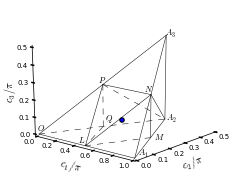

In [370]:
U.closest_unitary().show_in_weyl_chamber()

In [371]:
p = QDYN.pulse.Pulse(join(rf2, 'pulse.dat'))

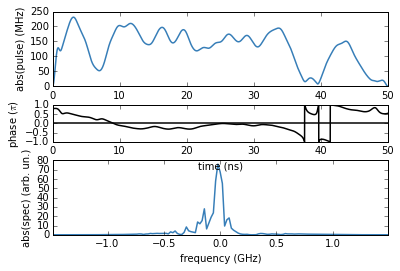

In [372]:
p.show()

In [420]:
rf3 = join(root, 'PE_LI_BGATE_50ns_cont2'); mkdir(rf3)

In [387]:
! cp {rf2}/* {rf3}/
! mv {rf3}/pulse.dat {rf3}/pulse.guess
! perl -p -i -e 's/LI_unitarity_weight = 0.5/LI_unitarity_weight = 0.9/g' {rf3}/config
! perl -p -i -e 's/J_T_conv = 1.0e-3/J_T_conv = 1.0e-5/g' {rf3}/config

In [388]:
proc7 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf3))

In [311]:
proc7.join()

<Process(Process-37, started)>

In [422]:
U = propagate(rf3, 'pulse.dat', rwa=True, force=True);

In [421]:
U.closest_unitary().concurrence()

1.0

In [401]:
U.pop_loss()

0.0065271044883082885

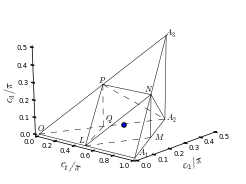

In [402]:
U.closest_unitary().show_in_weyl_chamber()

In [426]:
p = QDYN.pulse.Pulse(join(rf3, 'pulse.dat'))

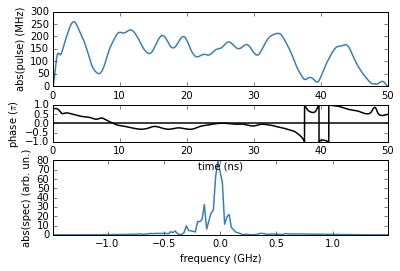

In [427]:
p.show()

It seems we will not get any better with the LI optimization. Maybe we can still improve by choosing a specfic representation of the BGATE and optimize towards that directly.

In [423]:
U.closest_unitary().weyl_coordinates()

(0.47491398, 0.24655105, 0.04142643)

In [408]:
BGATE2 = QDYN.weyl.closest_LI(U, 0.5, 0.25, 0.0)

In [416]:
GATE_RE['BGATE2'] = QDYN.linalg.vectorize(BGATE2).real
GATE_IM['BGATE2'] = QDYN.linalg.vectorize(BGATE2).imag

In [424]:
1-U.F_avg(BGATE2)

0.011140853072984624

In [425]:
U.F_sm(BGATE2)

0.98770570978084626

In [428]:
p.config_tgrid

u'tgrid: n = 1\n 1: t_start = 0_ns, t_stop = 50_ns, nt = 5000'

In [429]:
rf4 = join(root, 'PE_LI_BGATE_50ns_cont_SM'); mkdir(rf4)

In [430]:
# write runfolder
nt = 5000
write_config(join(rf4, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')
write_target_gate_dat(rf4, 'BGATE2')
p.write(join(rf4, 'pulse.guess'))

In [431]:
proc7 = system("./run_oct.py --continue --threads --target=target_gate.dat --rwa {rf}".format(rf=rf4))

In [432]:
proc7.join()

In [431]:
proc7 = system("./run_oct.py --continue --g_a_int_converged=1e-10 --threads --target=target_gate.dat --rwa {rf}".format(rf=rf4))

In [445]:
! sed -i.bak '/# converged/d' {rf4}/pulse.dat

In [446]:
proc7 = system("./run_oct.py --continue --g_a_int_converged=1e-10 --threads --target=target_gate.dat --rwa {rf}".format(rf=rf4))

In [432]:
proc7.join()

In [440]:
U = propagate(rf4, 'pulse.dat', rwa=True, force=True, keep=True);

In [434]:
U.pop_loss()

0.0071038382493430197

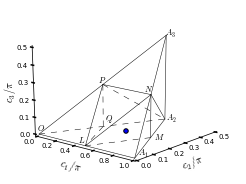

In [435]:
U.closest_unitary().show_in_weyl_chamber()

In [437]:
1-U.F_avg(BGATE2)

0.0072381945757277188

In [438]:
p = QDYN.pulse.Pulse(join(rf4, 'pulse.dat'))

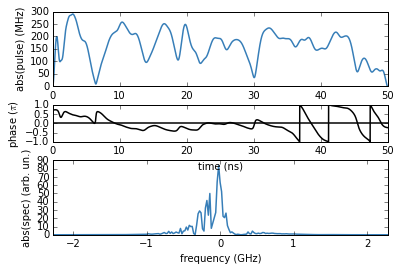

In [439]:
p.show()

In [441]:
dyn = QDYNTransmonLib.popdyn.PopPlot(rf4)

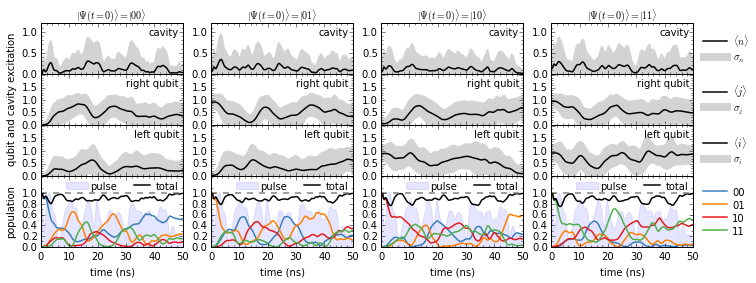

In [442]:
dyn.show()

In [444]:
rf4

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_LI_BGATE_50ns_cont_SM'

##### LI BGATE at $T = 20ns$

In [321]:
wd = 5.9325
rf = join(root, 'PE_LI_BGATE_20ns'); mkdir(rf)
T = 20

In [322]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_LI_BGATE_20ns'

In [163]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='LI', prop_guess='F')
write_target_gate_dat(rf, 'BGATE')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.pulse().write(join(rf, 'pulse.guess'))

In [164]:
proc10 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf))

In [165]:
proc10.join()

<Process(Process-24, started)>

In [447]:
rf2 = join(root, 'PE_LI_BGATE_20ns_cont'); mkdir(rf2)

In [326]:
! cp {rf}/* {rf2}/
! mv {rf2}/pulse.dat {rf2}/pulse.guess
! perl -p -i -e 's/LI_unitarity_weight = 0.01/LI_unitarity_weight = 0.5/g' {rf2}/config

In [327]:
proc10 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf2))

In [328]:
proc10

<Process(Process-39, started)>

In [374]:
U = propagate(rf2, 'pulse.dat', rwa=True, force=True);

In [375]:
U.closest_unitary().concurrence()

1.0

In [376]:
1-U.F_avg(sqrt_SWAP)

0.80120376144135808

In [377]:
U.pop_loss()

0.013383613413697981

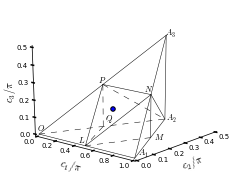

In [378]:
U.closest_unitary().show_in_weyl_chamber()

In [379]:
p = QDYN.pulse.Pulse(join(rf2, 'pulse.dat'))

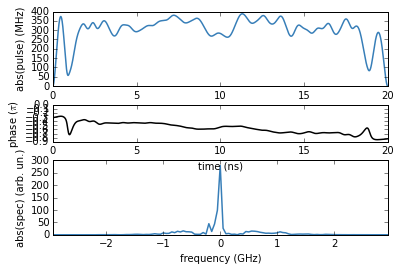

In [380]:
p.show()

In [448]:
rf3 = join(root, 'PE_LI_BGATE_20ns_cont2'); mkdir(rf3)

In [449]:
! cp {rf2}/* {rf3}/
! mv {rf3}/pulse.dat {rf3}/pulse.guess
! perl -p -i -e 's/LI_unitarity_weight = 0.5/LI_unitarity_weight = 0.9/g' {rf3}/config
! perl -p -i -e 's/J_T_conv = 1.0e-3/J_T_conv = 1.0e-5/g' {rf3}/config

In [450]:
proc10 = system("./run_oct.py --continue --threads --target=target_gate.dat --J_T_LI --rwa {rf}".format(rf=rf3))

In [451]:
proc10

<Process(Process-46, started)>

In [311]:
proc10.join()

<Process(Process-37, started)>

### Improved single-qubit gates

See notes for analysis

#### 50 ns, driving at the dressed qubit frequency

In [395]:
T = 50
nt = int(max(2000, 100 * w_max * T))
rf_HL = join(root, '50ns_w_dressed_H_left'); mkdir(rf_HL)
rf_HR = join(root, '50ns_w_dressed_H_right'); mkdir(rf_HR)
rf_SL = join(root, '50ns_w_dressed_Ph_left'); mkdir(rf_SL)
rf_SR = join(root, '50ns_w_dressed_Ph_right'); mkdir(rf_SR)
write_target_gate_dat(rf_HL, 'H_left')
write_target_gate_dat(rf_HR, 'H_right')
write_target_gate_dat(rf_SL, 'Ph_left')
write_target_gate_dat(rf_SR, 'Ph_right')
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
for rf in [rf_HL, rf_SL, rf_HR, rf_SR]:
    with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
        json.dump(vary, out_fh)
for rf in [rf_HL, rf_SL]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w1_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w1_dressed, 'w_d': w1_dressed},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))
for rf in [rf_HR, rf_SR]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w2_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w2_dressed, 'w_d': w2_dressed},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))


In [396]:
rf_HL

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/50ns_w_dressed_H_left'

In [100]:
proc_SQa1 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HL))

In [101]:
proc_SQa1

<Process(Process-7, started)>

In [103]:
proc_SQa2 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HR))
proc_SQa3 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SL))
proc_SQa4 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SR))

#### 50 ns, driving at center qubit frequency

In [21]:
root

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz'

In [69]:
T = 50
nt = int(max(2000, 100 * w_max * T))
rf_HL = join(root, '50ns_w_center_H_left'); mkdir(rf_HL)
rf_HR = join(root, '50ns_w_center_H_right'); mkdir(rf_HR)
rf_SL = join(root, '50ns_w_center_Ph_left'); mkdir(rf_SL)
rf_SR = join(root, '50ns_w_center_Ph_right'); mkdir(rf_SR)

In [454]:
write_target_gate_dat(rf_HL, 'H_left')
write_target_gate_dat(rf_HR, 'H_right')
write_target_gate_dat(rf_SL, 'Ph_left')
write_target_gate_dat(rf_SR, 'Ph_right')
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
for rf in [rf_HL, rf_SL, rf_HR, rf_SR]:
    with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
        json.dump(vary, out_fh)
for rf in [rf_HL, rf_SL]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w1_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': 5.9325, 'w_d': 5.9325},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))
for rf in [rf_HR, rf_SR]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w2_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': 5.9325, 'w_d': 5.9325},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))

In [168]:
proc_SQc1 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HL))

In [101]:
proc_SQc1

<Process(Process-7, started)>

In [170]:
proc_SQc2 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HR))
proc_SQc3 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SL))
proc_SQc4 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SR))

For $H_R$, the scan yielded a much too large amplitude, so we'll redo the optimization manually

In [31]:
write_target_gate_dat(rf_HR, 'H_right')
write_config(join(rf_HR, 'config'), T, nt, wc, w2, wd=5.9325,
             gate="target_gate.dat", J_T='SM', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': 5.9325, 'w_d': 5.9325},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf_HR, 'pulse_guess.json'))

In [32]:
proc_SQb2 = system("./run_oct.py --rwa --threads --continue --vary=E0 --E0-min=120 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HR))

In [29]:
proc_SQb2

<Process(Process-3, started)>

In [33]:
! cp {rf_HL}/config.oct {rf_HL}/config
! cp {rf_HR}/config.oct {rf_HR}/config
! cp {rf_SL}/config.oct {rf_SL}/config
! cp {rf_SR}/config.oct {rf_SR}/config

In [34]:
U_HL = propagate(rf_HL, 'pulse.dat', rwa=True, force=True, keep=True, use_threads=True)
U_HR = propagate(rf_HR, 'pulse.dat', rwa=True, force=True, keep=True, use_threads=True)
U_SL = propagate(rf_SL, 'pulse.dat', rwa=True, force=True, keep=True, use_threads=True)
U_SR = propagate(rf_SR, 'pulse.dat', rwa=True, force=True, keep=True, use_threads=True)

In [35]:
1-U_HL.F_avg(H_left)

0.0059745825024313248

In [36]:
1-U_HR.F_avg(H_right)

0.0076124506886767751

In [37]:
1-U_SL.F_avg(S_left)

0.006489536260246509

In [38]:
1-U_SR.F_avg(S_right)

0.0052242575581729067

In [70]:
p_HL = QDYN.pulse.Pulse(join(rf_HL, 'pulse.dat'))
p_HR = QDYN.pulse.Pulse(join(rf_HR, 'pulse.dat'))
p_SL = QDYN.pulse.Pulse(join(rf_SL, 'pulse.dat'))
p_SR = QDYN.pulse.Pulse(join(rf_SR, 'pulse.dat'))

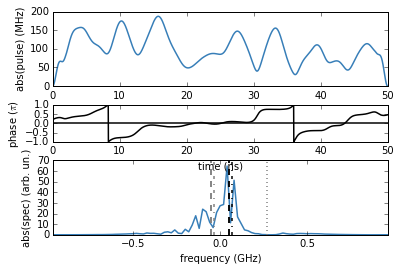

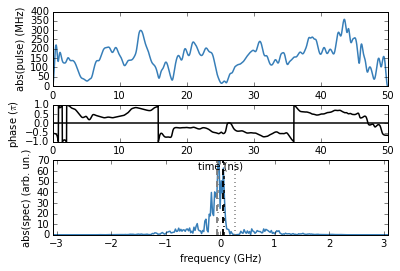

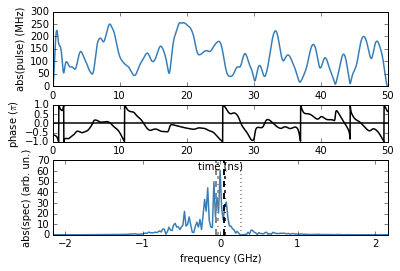

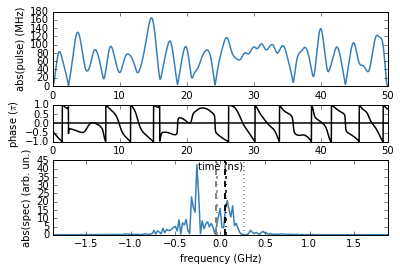

In [71]:
p_HL.show(mark_freqs=mark_freqs(rf_HL, transition_table))
p_HR.show(mark_freqs=mark_freqs(rf_HL, transition_table))
p_SL.show(mark_freqs=mark_freqs(rf_HL, transition_table))
p_SR.show(mark_freqs=mark_freqs(rf_HL, transition_table))

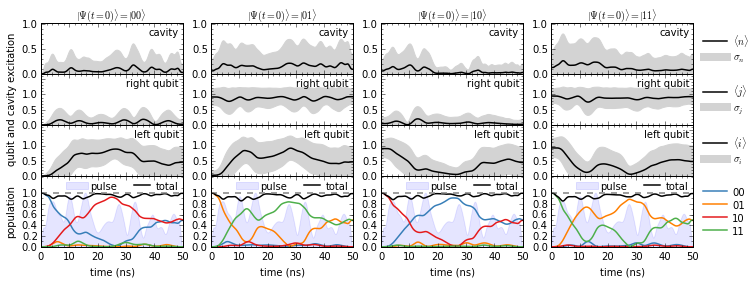

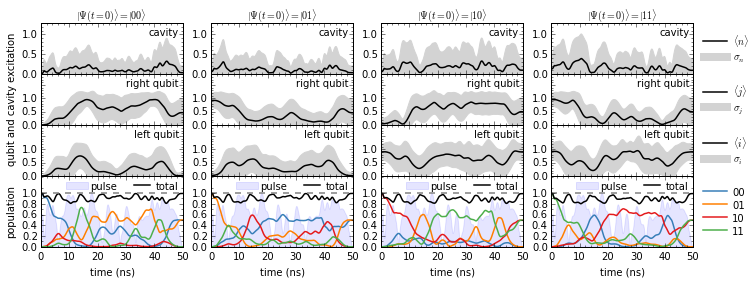

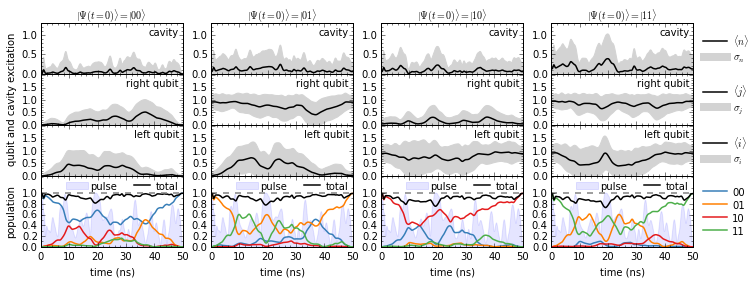

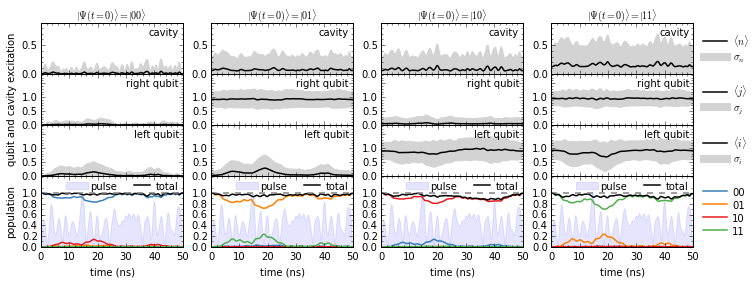

In [511]:
QDYNTransmonLib.popdyn.PopPlot(rf_HL).show()
QDYNTransmonLib.popdyn.PopPlot(rf_HR).show()
QDYNTransmonLib.popdyn.PopPlot(rf_SL).show()
QDYNTransmonLib.popdyn.PopPlot(rf_SR).show()

#### 40 ns, driving at the dressed qubit frequency

In [452]:
T = 40
nt = int(max(2000, 100 * w_max * T))
rf_HL = join(root, '40ns_w_dressed_H_left'); mkdir(rf_HL)
rf_HR = join(root, '40ns_w_dressed_H_right'); mkdir(rf_HR)
rf_SL = join(root, '40ns_w_dressed_Ph_left'); mkdir(rf_SL)
rf_SR = join(root, '40ns_w_dressed_Ph_right'); mkdir(rf_SR)
write_target_gate_dat(rf_HL, 'H_left')
write_target_gate_dat(rf_HR, 'H_right')
write_target_gate_dat(rf_SL, 'Ph_left')
write_target_gate_dat(rf_SR, 'Ph_right')
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
for rf in [rf_HL, rf_SL, rf_HR, rf_SR]:
    with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
        json.dump(vary, out_fh)
for rf in [rf_HL, rf_SL]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w1_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w1_dressed, 'w_d': w1_dressed},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))
for rf in [rf_HR, rf_SR]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w2_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w2_dressed, 'w_d': w2_dressed},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))


In [107]:
proc_SQb1 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HL))

In [ ]:
proc_SQb2 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HR))
proc_SQb3 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SL))
proc_SQb4 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SR))

#### 40 ns, driving at center qubit frequency

In [171]:
T = 40
nt = int(max(2000, 100 * w_max * T))
rf_HL = join(root, '40ns_w_center_H_left'); mkdir(rf_HL)
rf_HR = join(root, '40ns_w_center_H_right'); mkdir(rf_HR)
rf_SL = join(root, '40ns_w_center_Ph_left'); mkdir(rf_SL)
rf_SR = join(root, '40ns_w_center_Ph_right'); mkdir(rf_SR)
write_target_gate_dat(rf_HL, 'H_left')
write_target_gate_dat(rf_HR, 'H_right')
write_target_gate_dat(rf_SL, 'Ph_left')
write_target_gate_dat(rf_SR, 'Ph_right')
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
for rf in [rf_HL, rf_SL, rf_HR, rf_SR]:
    with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
        json.dump(vary, out_fh)
for rf in [rf_HL, rf_SL]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w1_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': 5.9325, 'w_d': 5.9325},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))
for rf in [rf_HR, rf_SR]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w2_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': 5.9325, 'w_d': 5.9325},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.write(join(rf, 'pulse_guess.json'))


In [172]:
rf_HL

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/40ns_w_center_H_left'

In [173]:
proc_SQd1 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HL))

In [174]:
proc_SQd1

<Process(Process-29, started)>

In [175]:
proc_SQd2 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_HR))
proc_SQd3 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SL))
proc_SQd4 = system("./run_oct.py --rwa --threads --continue --scan=systematic_variation.json --vary=E0 --E0-min=100 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf_SR))